# *A Statistical Analysis of Arizonan Fair Market Rents from 2010-2019*

## Matthias Mitchell

***
### Table of Contents
* Introduction
    * [Description](#s1_1)
* Preliminary
    * [Importing CPI Data](#s2_1)
    * [Webscraping FMR Data](#s2_2)
    * [Cleaning Data](#s2_3)
    * [Adjustments for Inflation](#s2_4)
* Mean FMR by Year
    * [Boxplots of FMRs](#s3_1)
    * [ANOVA F-Tests of General Change](#s3_2)
    * [T-Tests of Overall Change](#s3_3)
* FMR by Population Size
    * [Exploratory](#s4_1)
    * [Linear Regression](#s4_2)
* FMR by Location and Time
    * [Chi-Square Analysis](#s5_1)
* Conclusion
    * [Results](#s6_1)
***

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import scipy.stats as stats
import re
import itertools as it
import math
import numpy as np
from sklearn.linear_model import LinearRegression as lm

<a name="s1_1"></a>Fair Market Rent (FMR) is calculated as the gross renting cost for a standard, quality housing unit and is determined yearly through nationwide surveys by the Department of Housing and Urban Development (HUD). FMRs are grouped first by counties and second by the number of bedrooms (BRs) in the unit (ranging from 0 BR-4 BR).

Our intention is to determine whether there is any statistically significant relation between FMR (by county and #BR) and the last decade of 2010-2019 specifically within Arizona (i.e. a general increase/decrease in renting costs). We will begin with some general explorations of the data, adjust for inflation rates (to the best of our ability), then perform a chi-square test to determine any relationship between counties (rows) and years (columns), evaluated by FMR.

We will reference <https://www.rentdata.org/states/arizona> which provides the necessary data on FMRs per county and by number of BRs, as well as counties' estimated populations. For this analysis, we will only focus on 0 BR homes (studio apartments, etc.); however, the analysis would be similar for other sized homes.

To account for inflation, we have imported data from <https://www.bls.gov/cpi/data.htm> which has been filtered (Series ID: CUUR0000SA0) to give the mean annual Consumer Price Index (CPI) for an average U.S. city. This should be sufficient to adjust for inflation.

### <a name="s2_1"></a>CPI by Year

In [2]:
cpi_df = pd.read_csv('cpi_2010-2019.csv', delimiter = '\t', index_col = 'Year')
cpi_base = cpi_df.at[2019,'Annual']
cpi_df['Relative'] = cpi_base / cpi_df['Annual']

cpi_df

,Annual,Relative
Year,,
2010,218.056,1.172437
2011,224.939,1.136561
2012,229.594,1.113518
2013,232.957,1.097443
2014,236.736,1.079924
2015,237.017,1.078644
2016,240.007,1.065206
2017,245.120,1.042987
2018,251.107,1.018120


### <a name="s2_2"></a>Webscraping

In [3]:
br = 0 # Change this to analyze different num BR
years = range(2010,2020)

# Lists to become columns
cum_counties = []
cum_fmrs = []
cum_years = []
cum_pops = []

for i in years:
    page = requests.get('https://www.rentdata.org/states/arizona/' + str(i))
    soup = BeautifulSoup(page.content, 'html.parser')
    tables = soup.find_all('td')
    
    # Temporary lists
    counties = []
    fmrs = []
    year = []
    pops = []

    j = 0
    while j < len(tables):
        # The website HTML is structured such that the table rows are evenly spaced
        if 'title' in str(tables[j]):
            counties.append(tables[j].get_text().strip())
            j = j + br + 1 # Distance from county name to FRM data
            fmrs.append(tables[j].get_text().strip())
            year.append(i) # Repeated column
            j = j + 5 - br # Distance from FRM data to population stats
            pops.append(tables[j].get_text().strip())
        else:
            j = j + 1 # Increment otherwise
    
    cum_counties.append(counties)
    cum_fmrs.append(fmrs)
    cum_years.append(year)
    cum_pops.append(pops)

# Merge the inner lists
cum_counties = list(it.chain.from_iterable(cum_counties))
cum_fmrs = list(it.chain.from_iterable(cum_fmrs))
cum_years = list(it.chain.from_iterable(cum_years))
cum_pops = list(it.chain.from_iterable(cum_pops))

# Manipulate to fit into a dataframe
fmr_df = pd.DataFrame(list(zip(cum_years, cum_counties, cum_pops, cum_fmrs)), columns = ['Year','County','Population','FMR'])
fmr_df

,Year,County,Population,FMR
0,2010,Apache County,"69,423",$433
1,2010,Cochise County,"117,755",$508
2,2010,Coconino County\nMetro,"116,320",$820
3,2010,Gila County,"51,335",$554
4,2010,Graham County,"33,489",$576
...,...,...,...,...
145,2019,Pima County\nMetro,"980,263",$580
146,2019,Pinal County\nMetro,"375,770",$744
147,2019,Santa Cruz County,"47,420",$557
148,2019,Yavapai County\nMetro,"211,033",$717


### <a name="s2_3"></a>Cleaning DataFrame

In [4]:
metro = []
county = []
pop = []
fmr_int = []

for i in fmr_df['County']:
    if 'Metro' in i:
        metro.append(True) # Keep "Metro" out of county names
    else:
        metro.append(False)
    county.append(re.split(' ', i)[0]) # Only take the first word of county names

for i in fmr_df['FMR']:
    fmr_int.append(float(re.sub('[$,]', '', i))) # Convert currency format to float

for i in fmr_df['Population']:
    pop.append(int(re.sub(',', '', i))) # Convert string to int

# Create/update columns
fmr_df['Metro'] = metro
fmr_df['County'] = county
fmr_df['Population'] = pop
fmr_df['FMR'] = fmr_int

fmr_df

,Year,County,Population,FMR,Metro
0,2010,Apache,69423,433.0,False
1,2010,Cochise,117755,508.0,False
2,2010,Coconino,116320,820.0,True
3,2010,Gila,51335,554.0,False
4,2010,Graham,33489,576.0,False
...,...,...,...,...,...
145,2019,Pima,980263,580.0,True
146,2019,Pinal,375770,744.0,True
147,2019,Santa,47420,557.0,False
148,2019,Yavapai,211033,717.0,True


### <a name="s2_4"></a>Adjusting for Inflation

Generally, cost adjusted for inflation is

$C_{\text{adj, }N} = \frac{CPI_{\text{base}}}{CPI_N} \cdot C_{\text{old, }N}$

for index $N$ and cost $C$.

In [5]:
fmr_adj = []

cpi_df.loc[2010,'Relative']

# Calculation to adjust for inflation
for i in range(len(fmr_df)):
    fmr_adj.append(round(cpi_df.loc[fmr_df.loc[i,'Year'],'Relative'] * fmr_df.loc[i,'FMR'], 2))

# Create column of adjusted FMRs
fmr_df['Adjusted'] = fmr_adj
fmr_df

,Year,County,Population,FMR,Metro,Adjusted
0,2010,Apache,69423,433.0,False,507.67
1,2010,Cochise,117755,508.0,False,595.60
2,2010,Coconino,116320,820.0,True,961.40
3,2010,Gila,51335,554.0,False,649.53
4,2010,Graham,33489,576.0,False,675.32
...,...,...,...,...,...,...
145,2019,Pima,980263,580.0,True,580.00
146,2019,Pinal,375770,744.0,True,744.00
147,2019,Santa,47420,557.0,False,557.00
148,2019,Yavapai,211033,717.0,True,717.00


### <a name="s3_1"></a>Boxplots

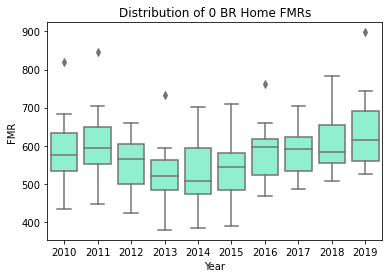

In [6]:
sns.boxplot(x = fmr_df['Year'], y = fmr_df['FMR'], color = 'aquamarine')
plt.ylabel('FMR')
plt.title('Distribution of 0 BR Home FMRs')
plt.show()

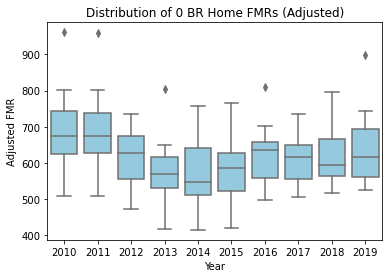

In [7]:
sns.boxplot(x = fmr_df['Year'], y = fmr_df['Adjusted'], color = 'skyblue')
plt.ylabel('Adjusted FMR')
plt.title('Distribution of 0 BR Home FMRs (Adjusted)')
plt.show()

It should be noted that since CPI does not include real estate prices$-$as they contain future value and are considered investments$-$this is a shaky way to adjust for inflation. However, since the HUD calculates FMR from rental properties, we may be partially avoiding this issue. Nonetheless, we will treat adjusted and unadjusted FMRs with similar validity.

<a name="s3_2"></a>Let us conduct 2 ANOVA F-tests under the hypothesis:

$H_0 : \mu_{2010} = \mu_{2011} = ... = \mu_{2019}$

$H_A : \exists (\mu_M , \mu_N) , \mu_M \neq \mu_N$.

In [8]:
stats.f_oneway(
    fmr_df['FMR'][fmr_df['Year'] == 2010],
    fmr_df['FMR'][fmr_df['Year'] == 2011],
    fmr_df['FMR'][fmr_df['Year'] == 2012],
    fmr_df['FMR'][fmr_df['Year'] == 2013],
    fmr_df['FMR'][fmr_df['Year'] == 2014],
    fmr_df['FMR'][fmr_df['Year'] == 2015],
    fmr_df['FMR'][fmr_df['Year'] == 2016],
    fmr_df['FMR'][fmr_df['Year'] == 2017],
    fmr_df['FMR'][fmr_df['Year'] == 2018],
    fmr_df['FMR'][fmr_df['Year'] == 2019]
)

F_onewayResult(statistic=3.307450871287303, pvalue=0.0010913292974610855)

In [9]:
stats.f_oneway(
    fmr_df['Adjusted'][fmr_df['Year'] == 2010],
    fmr_df['Adjusted'][fmr_df['Year'] == 2011],
    fmr_df['Adjusted'][fmr_df['Year'] == 2012],
    fmr_df['Adjusted'][fmr_df['Year'] == 2013],
    fmr_df['Adjusted'][fmr_df['Year'] == 2014],
    fmr_df['Adjusted'][fmr_df['Year'] == 2015],
    fmr_df['Adjusted'][fmr_df['Year'] == 2016],
    fmr_df['Adjusted'][fmr_df['Year'] == 2017],
    fmr_df['Adjusted'][fmr_df['Year'] == 2018],
    fmr_df['Adjusted'][fmr_df['Year'] == 2019]
)

F_onewayResult(statistic=3.609587575945325, pvalue=0.00045134936703110845)

<a name="s3_3"></a>Both results yield significant evidence at the 1% level that some of the means differ. However, as to the general increase or decrease in FMR, we can conduct 2 t-tests on the years 2010 and 2019 under the hypothesis:

$H_0 : \mu_{2010} = \mu_{2019}$

$H_A : \mu_{2010} \neq \mu_{2019}$.

In [10]:
x2010 = fmr_df['FMR'][fmr_df['Year'] == 2010].mean()
s2010 = fmr_df['FMR'][fmr_df['Year'] == 2010].std()
n2010 = fmr_df['FMR'][fmr_df['Year'] == 2010].count()

x2019 = fmr_df['FMR'][fmr_df['Year'] == 2019].mean()
s2019 = fmr_df['FMR'][fmr_df['Year'] == 2019].std()
n2019 = fmr_df['FMR'][fmr_df['Year'] == 2019].count()

tstat = (x2010-x2019) / math.sqrt(s2010**2/n2010 + s2019**2/n2019)

df = (s2010**2/n2010 + s2019**2/n2019)**2 / ( (s2010**2/n2010)**2/(n2010-1) + (s2019**2/n2019)**2/(n2019-1) )

t_dist = stats.t(df)
pval = (t_dist.cdf(tstat)) * 2

pval

0.1911661727349805

In [11]:
# Similar calculations for adjusted FMRs
x2010a = fmr_df['Adjusted'][fmr_df['Year'] == 2010].mean()
s2010a = fmr_df['Adjusted'][fmr_df['Year'] == 2010].std()
n2010a = fmr_df['Adjusted'][fmr_df['Year'] == 2010].count()

x2019a = fmr_df['Adjusted'][fmr_df['Year'] == 2019].mean()
s2019a = fmr_df['Adjusted'][fmr_df['Year'] == 2019].std()
n2019a = fmr_df['Adjusted'][fmr_df['Year'] == 2019].count()

tstata = (x2010a-x2019a) / math.sqrt(s2010a**2/n2010a + s2019a**2/n2019a)

dfa = (s2010a**2/n2010a + s2019a**2/n2019a)**2 / ( (s2010a**2/n2010a)**2/(n2010a-1) + (s2019a**2/n2019a)**2/(n2019a-1) )

t_dista = stats.t(dfa)
pvala = (1 - t_dista.cdf(tstata)) * 2

pvala

0.16371073989296492

In both cases we have insufficient evidence to reject the null hypothesis, suggesting that mean FMR has not increased over the last interval of a decade.

### <a name="s4_1"></a>FMR and Population Size

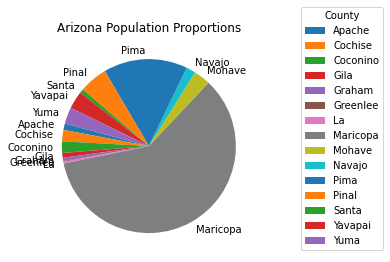

In [12]:
az_pop = fmr_df.groupby('County').mean()[['Population']]
plt.pie(az_pop['Population'], labels = fmr_df['County'].unique(), startangle = 165)
plt.legend(title = 'County', loc = 'lower right', bbox_to_anchor = (1.6,0))
plt.title('Arizona Population Proportions')
plt.show()

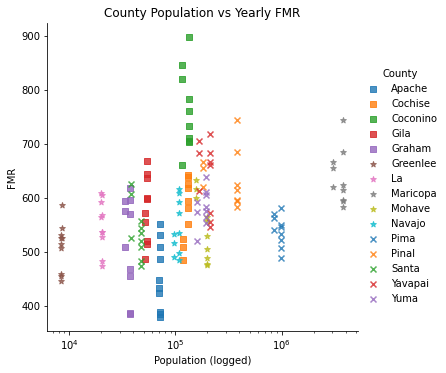

In [13]:
# Ran out of colors, using shapes too
sns.lmplot(x = 'Population', y = 'FMR', data = fmr_df, hue = 'County', fit_reg = False, palette = 'tab10', markers = ['s','s','s','s','s','*','*','*','*','*','x','x','x','x','x'])
plt.xscale('log')
plt.xlabel('Population (logged)')
plt.title('County Population vs Yearly FMR')
plt.show()

<a name="s4_2"></a>How good of a predictor of FMR is logged county population? We will test the hypothesis:

$H_0 : \beta_1 = 0$

$H_A : \beta_1 \neq 0$.

In [14]:
pop_log = np.log10(fmr_df['Population']) # Log x axis

pop_log_fmr_lm = stats.linregress(pop_log, fmr_df['Population']) # Perform regression

print('Slope: ', pop_log_fmr_lm[0])
print('R-squared: ', pop_log_fmr_lm[2]**2)
print('P-value: ', pop_log_fmr_lm[3])

Slope:  1087154.651424701
R-squared:  0.5864917425507118
P-value:  3.546142701310493e-30


### <a name="s5_1"></a>Chi-Square Analysis

$H_0 : \text{There is no relation between counties and time in terms of FMR}$

In [15]:
fmr_df_grouped = fmr_df.groupby('Year')
fmr_matrix = []

# Transform dataframe into a matrix suitable for chi-square testing
for i in years:
    fmr_matrix.append(fmr_df_grouped.get_group(i)['FMR'].tolist())

fmr_matrix = np.array(fmr_matrix).T
pd.DataFrame(fmr_matrix)

,0,1,2,3,4,5,6,7,8,9
0,433.0,447.0,424.0,379.0,385.0,389.0,552.0,486.0,508.0,530.0
1,508.0,524.0,484.0,551.0,641.0,581.0,625.0,594.0,617.0,638.0
2,820.0,845.0,660.0,733.0,702.0,710.0,761.0,704.0,782.0,898.0
3,554.0,571.0,487.0,520.0,515.0,597.0,636.0,599.0,643.0,668.0
4,576.0,594.0,508.0,387.0,384.0,454.0,467.0,569.0,595.0,617.0
5,526.0,543.0,586.0,446.0,454.0,458.0,507.0,515.0,530.0,526.0
6,591.0,609.0,564.0,483.0,473.0,536.0,527.0,537.0,568.0,605.0
7,654.0,666.0,619.0,593.0,614.0,582.0,596.0,624.0,684.0,744.0
8,615.0,633.0,599.0,488.0,475.0,477.0,505.0,529.0,564.0,556.0
9,516.0,532.0,490.0,498.0,485.0,534.0,609.0,592.0,572.0,615.0


In [16]:
fmr_chisq = stats.chi2_contingency(fmr_matrix) # Chi-square test
fmr_chisq

print('Chi-square stat: ', fmr_chisq[0])
print('P-value: ', fmr_chisq[1])
print('Degrees of freedom: ', fmr_chisq[2])
print('\nResiduals:')

# Convert to dataframe for appearances
residuals = pd.DataFrame(fmr_matrix - fmr_chisq[3], columns = years, index = fmr_df['County'].unique())
residuals

Chi-square stat:  394.38176517466025
P-value:  2.0355140842487197e-29
Degrees of freedom:  126

Residuals:


,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Apache,-33.210193,-33.115909,-11.396391,-31.798022,-28.220988,-37.283933,93.638109,24.899104,30.043691,26.444532
Cochise,-84.713290,-86.392231,-69.538363,28.734612,115.654191,39.046701,42.264598,7.782382,9.353362,-2.191961
Coconino,36.812129,38.451876,-71.423674,42.899197,7.828850,-6.115630,-9.003486,-70.604748,-20.920206,52.075692
Gila,-41.490187,-42.251955,-69.131724,-4.712232,-12.807086,52.507617,50.534447,10.035917,32.506501,24.808701
Graham,46.229714,48.428183,13.244472,-79.803577,-85.556874,-30.400737,-53.851997,45.035580,51.882209,44.793026
Greenlee,2.400597,3.783126,97.007495,-15.366144,-10.087370,-20.758329,-7.784996,-2.861165,-6.791434,-39.541779
La,26.055683,27.205011,36.395240,-14.796942,-27.733044,19.437537,-28.433900,-21.752972,-11.178029,-5.198585
Maricopa,-1.759142,-9.318561,6.582751,15.182177,32.774097,-17.599902,-48.719925,-24.572537,11.719076,35.711965
Mohave,55.403781,56.712627,76.389860,-5.084500,-20.992807,-34.672376,-45.175833,-24.463484,-9.695186,-48.422083
Navajo,-43.801915,-44.499204,-32.802240,4.734252,-11.175124,22.139544,58.621934,38.333074,-1.906064,10.355744


We can confidently claim claim that there is a relationship counties and time when analyzing FMR (not adjusted for inflation, although the analysis with inflation would be nearly identical).

### <a name="s6_1"></a>Conclusion

We first came across the curious conclusion that, although mean FMR has almost certainly varied over the last decade, mean FMR in 2010 versus 2019 is not statistically significant. Whether this implies that 0 BR housing prices have not significantly increased over time in each Arizonan county is explored in the chi-square test.

We later found that, given a population size, we can very roughly estimate FMR. If we included information on locations, we might be able to more closely predict this, although a decision tree/random forest implementation would likely be more appropriate.

Our final analysis determined that there is a statistically significant relationship between Arizonan counties and time when studying FMR. The specifics are more nuanced but can be studied in the dataframe of residuals.